In [ ]:
###############################################
'''
                 PIPE LINE 2.0
                 Data 불러오기
  melspec computing 후 저장한 Label_IDS.json 과
        rich_train_meta.csv 불러오기
        
            dataset으로 저장
                                              '''
###############################################


''' 
    




'''


In [4]:
import numpy as np
import librosa as lb
import librosa.display as lbd
import soundfile as sf
from  soundfile import SoundFile
import pandas as pd
from  IPython.display import Audio
from pathlib import Path

import torch
from torch import nn, optim
from  torch.utils.data import Dataset, DataLoader
import torchvision.models as models

from matplotlib import pyplot as plt

import os, random, gc
import re, time, json
from  ast import literal_eval


from IPython.display import Audio
from sklearn.metrics import label_ranking_average_precision_score

from tqdm.notebook import tqdm
import joblib

import pretrainedmodels

from sklearn.model_selection import StratifiedKFold


In [5]:
import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm  ##다양한 model들 있는 라이브러리

In [6]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [7]:
##################
## Seed Setting ##
##################

def make_seed(seed = 499):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    os.environ['PYTHONHASHSEED'] = str(seed)
    
make_seed()

Num_classes = 397 ##label할 classes 갯수(ex 새 종류)
SR = 32000 #sampling rate
Duration = 7 #time
seed = 599
n_splits = 5

In [8]:
#################
## Path manage ##
#################

Root_Path = '/Users/ansgh/PycharmProjects/kaggle_notebook/input/birdclef-2021'

Train_short_root = Path(Root_Path + str('/train_short_audio'))
Train_metadata_root = Path(Root_Path + str('/train_metadata.csv'))

Train_audio_image_save_root = Path(Root_Path + str('/audio_images'))
Train_audio_image_save_root.mkdir(exist_ok=True, parents=True)

## File 내부 확인 
file_list = os.listdir(Root_Path)
print(file_list)


###
##  Mel 이미지를 만들었으니 이제는 train이랑 model 만들어야함
###

## df.to_csv(Root_Path + '/rich_train_metadata.csv', index=True) 있었음

Rich_train_path = Path(Root_Path + '/rich_train_metadata.csv')
Train_label_paths = Path(Root_Path + '/Label_IDS.json')
MODEL_ROOT = Path(".") ##save 할때 씀

# 만약 n개로 쪼개진 파일이라면(파일이름이 d-part1, d-part2, d-part3 등으로 돼 있다면)
# Rich_train_path = sorted(Path("블라블라/d-part?./rich_train_metadata.csv")) 로 읽고
# get_df에서 for path in file_path 로 하나씩 읽으면 됨. d-part?랑 sorted 때문에 iter 사용가능

['audio_images', 'Label_IDS.json', 'Label_IDS_0.json', 'resnet152_sr32000_d7_v1_v1', 'resnext_sr32000_d7_v1_v1', 'rich_train_metadata.csv', 'rich_train_metadata_0.csv', 'sample_submission.csv', 'test.csv', 'test_soundscapes', 'train_metadata.csv', 'train_short_audio', 'train_soundscapes', 'train_soundscape_labels.csv']


In [9]:
#####################################
##   저장된 Data Frame 불러와서    ##
##    impath 맨 뒤에 붙이기        ##
##    make_df도 있음 초반부에      ##
#####################################
## get_df 에서 학습용 df 전처리 하는게 유리할것. (df.rating이 일정이하면 학습에 안쓰겠다 등등)

def get_df(file_path = Rich_train_path, label_path = Train_label_paths):
    
    df = None  #빈 df 생성
    Label_IDS = {}  #빈 label 생성
    
    
    temp = pd.read_csv(str(file_path), index_col = False) ##index_col = False면 column을 index로 안쓰고 순서대로 index부여
    
    temp['impath'] = temp.apply(lambda row: file_path.parent/'audio_images/{}/{}.npy'.format(row.primary_label, row.filename), axis=1)
    #impath = sound_path + audio_images + primary_label + filename 으로 불러오겠다
        
    df = temp if df is None else df.append(temp)
        
        
    df['secondary_labels'] = df['secondary_labels'].apply(literal_eval) ## 예를들어 second_label에 ['amegfi'] 를 [amegfi] 로 바꿔줌
        
    
    with open(str(label_path)) as f:
        Label_IDS.update(json.load(f))
                
    return Label_IDS, df




''' n개로 쪼개진 파일일때 예시

def get_df(file_path = Rich_train_path, label_path = Train_label_paths):
    
    df = None  #빈 df 생성
    Label_IDS = {}  #빈 label 생성
    
    for path in file_paths:
        temp = pd.read_csv(str(file_path), index_col = 0)
        temp['impath'] = temp.apply(lambda row: file_path.parent/'audio_images/{}/{}.npy'.format(row.primary_label, row.filename), axis=1)
        
        df = temp if df is None else df.append(temp)
        
        
        df['secondary_labels'] = df['secondary_labels'].apply(literal_eval) ## 예를들어 second_label에 ['amegfi'] 를 [amegfi] 로 바꿔줌
        
    for path in label_path:
        with open(str(path)) as f:
            Label_IDS.update(json.load(f))
                
    return Label_IDS, df

'''

" n개로 쪼개진 파일일때 예시\n\ndef get_df(file_path = Rich_train_path, label_path = Train_label_paths):\n    \n    df = None  #빈 df 생성\n    Label_IDS = {}  #빈 label 생성\n    \n    for path in file_paths:\n        temp = pd.read_csv(str(file_path), index_col = 0)\n        temp['impath'] = temp.apply(lambda row: file_path.parent/'audio_images/{}/{}.npy'.format(row.primary_label, row.filename), axis=1)\n        \n        df = temp if df is None else df.append(temp)\n        \n        \n        df['secondary_labels'] = df['secondary_labels'].apply(literal_eval) ## 예를들어 second_label에 ['amegfi'] 를 [amegfi] 로 바꿔줌\n        \n    for path in label_path:\n        with open(str(path)) as f:\n            Label_IDS.update(json.load(f))\n                \n    return Label_IDS, df\n\n"

In [12]:
Lable_IDS, df = get_df()

In [14]:
#########################################
##   불러온 Data Frame 에 맞는         ##
##    impath에 해당하는 npy 불러와서   ##
##        dic으로 매칭                 ##
#########################################

Max_read_samples = 5 #메모리 아끼려고 5개만 불러오자 ##load_row에서 return row.filename, np.load(str(row.impath))[:MAX_READ_SAMPLES] 사용
def load_data(df):
    
    '''''''''''' ##여기 수정해서 row 받을때 quality 좋은것만 받을것
    
    def load_row(row):
        # filename = .ogg,  impath = .npy
        return row.filename, np.load(str(row.impath))
    
    
    pool = joblib.Parallel(4) #병렬처리
    mapper = joblib.delayed(load_row)
    tasks = [mapper(row) for row in df.itertuples(False)]
    res = pool(tqdm(tasks))
    res = dict(res)
    
    return res

In [15]:
## filename이랑 음성.npy랑 dic 타입으로 저장
audio_image_store = load_data(df)

  0%|          | 0/62874 [00:00<?, ?it/s]

In [16]:
## audio_image가 잘 저장됐는지 확인(길이로 대강만 보자 일단)
len(audio_image_store)

62874

In [17]:
###################################
##        Dataset 만들기          ##
##    numpy 3층으로 image 쌓고    ##
##     label은  smoothing 해서    ##
##         image, label 반환      ##
####################################

class BirdClefDataset(Dataset):
    
    def __init__(self, audio_image_store, meta, sr=SR, is_train=True, num_classes=Num_classes, duration=Duration):
        
        self.audio_image_store = audio_image_store ##audio np array랑 filename 저장된 dic
        self.meta = meta.copy().reset_index(drop=True) ##meta는 df
        self.sr = sr
        self.is_train = is_train
        self.num_classes = num_classes
        self.duration = duration
        self.audio_length = self.duration * self.sr
        
    
    def normalize(self, image):
        image = image.astype('float32', copy=False) / 255.0
        image = np.stack([image, image, image])
        return image
    
    def __len__(self):
        return len(self.meta)
    
    
    def find_mid_img(self, image):
        list = []
        for i in range(len(image)):
            list.append(image[i].sum())
        
        list = sorted(list)
        list[len(image)//2]
    
        for i in range(len(image)):
            list[i] == image[i].sum()
            return image[i]
    
    
    
    ##이 dataset의 단점이 있는 파트
    def __getitem__(self, idx):
        row = self.meta.iloc[idx]  #df에서 데이터 하나 불러옴
        image = self.audio_image_store[row.filename] #불러온 데이터의 filename으로 audio_image_store에서 image에 해당하는 np array 받아서 image에 저장
        
        
        #방법 1
        #image에 저장된 np array는 (x, 128, 281)로써, 음성(.ogg)가 25초라면 7초씩 저장했으므로 x==4, 이미지크기==128,281 이라는 뜻. len(image)는 맨 앞 x를 반환한다.
        #즉 윗줄이 뜻하는 것은 AudioToImage 클래스로 image에 저장시킨 7초짜리 x개의 영상중 랜덤으로 하나만 쓰겠다는 뜻이다.
        #이것은 단점이 되는데 만약 랜덤하게 뽑은 음성이 표본을 제대로 반영하지 못할수 있기 때문이다.
        image = image[np.random.choice(len(image))] 
        
        
        #방법2
        # 랜덤하게 안뽑고 이미지 중에서 노이즈는 상수라고 쳤을때 신호가 있으면 값이 더 커질것.
        # 따라서 중간값 혹은 최댓값을 갖게 뽑아서 써보자
        ##image = self.find_mid_img(image)
        
        
        image = self.normalize(image)
        
        ## Label smoothing. 해당 라벨은 0.995, 나머지는 0.0025로 초기화
        t = np.zeros(self.num_classes, dtype=np.float32) + 0.0025 
        t[row.label_id] = 0.995
        
        return image, t

In [18]:
dataset = BirdClefDataset(audio_image_store, meta=df, sr=SR, duration=Duration, is_train=True)

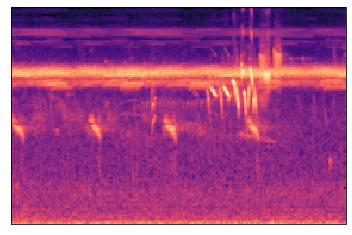

In [19]:
#만든 dataset 확인하기

x, y = dataset[np.random.choice(len(dataset))] #random으로 ds에서 하나 받아오기
x.shape, y.shape, np.where(y>=0.5) # x는 3층(image, image, image), y는 label, np.where은 하나뽑은 녀석이 label에서 몇번에 등록된 해당하는지
lbd.specshow(x[0])

In [ ]:
###############################################
'''
                 PIPE LINE 2.5
          Training, evaluate 모델 만들기
                                              '''
###############################################


''' 1 train == x fold (x == 데이터셋 쪼갠 수,, 예 k fold)
    1 fold  == x epochs (x == 반복학습 수)
    1 epoch == x step(x는 dataset에서 학습해야되는 step수)'''

'''
    net (model) 정의 블럭 -> get_model
    get_model 호출 블럭 -> one fold
    criterion 정의 블럭 -> one_fold
    scheduler 정의 -> one fold
    data_loader 정의 -> one fold
    
    
    epoch 설정 -> train
    n_split 설정 -> split
'''



In [20]:
## Fold 계산 후 값을 저장하기 위한 autosave
class AutoSave:
    def __init__(self, top_k=2, metric='f1', mode='min', root=None, name='ckpt'):
        self.top_k = top_k
        self.logs = []
        self.metric = metric
        self.mode = mode
        self.root = Path(root or Root_Path)
        assert self.root.exists()
        self.name = name
        
        self.top_models = []
        self.top_metrics = []
    
    def rank(self, val):
        r = -1
        for top_val in self.top_metrics:
            if val <= top_val:
                return r
            r += 1
            
        return r
    
    def log(self, model, metrics):
        metric = metrics[self.metric] #list에 f1 저장
        rank = self.rank(metric) #성능(f1) 레이팅
        
        self.top_metrics.insert(rank+1, metric) 
        if len(self.top_metrics) > self.top_k:
            self.top_metrics.pop(0)
            
        self.logs.append(metrics)
        self.save(model, metric, rank, metrics['epoch'])
        
    def save(self, model, metric, rank, epoch):
        t = time.strftime("%Y%m%d%H%M%S")
        name = "{}_epoch_{:02d}_{}_{:.04f}_{}".format(self.name, epoch, self.metric, metric, t)
        name = re.sub(r"[^\w_-]", "", name) + ".pth"
        path = self.root.joinpath(name)
        
        old_model = None
        self.top_models.insert(rank+1, name)
        if len(self.top_models) > self.top_k:
            old_model = self.root.joinpath(self.top_models[0])
            self.top_models.pop(0)
            
        torch.save(model.state_dict(), path.as_posix())
        
        if old_model is not None:
            old_model.unlink()
        self.to_json()
        
        
        
    def to_json(self):
        name = "{}_logs".format(self.name)
        name = re.sub(r"[^\w_-]", "", name) + ".json"
        path = self.root.joinpath(name)

        with path.open("w") as f:
            json.dump(self.logs, f, indent=2)

In [21]:
Train_Batch_Size = 8
Train_Num_Workers = 0

Val_Batch_Size = 8
Val_Num_Workers = 0

In [22]:
#############################################
##             기본 conv 블럭              ##
## 패딩, 노말라이제션, active func 등 묶음 ##
#############################################



def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky = True, use_inst_norm=True, use_pad=True):
    
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)
     
    
    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)
        
        
    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()
    
    return nn.Sequential(conv, norm, actv)

In [23]:
###############################
##          Resblock         ##
## 안에 더 deep 하게 가능    ##
###############################

class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        models = list()
        
        models.append(Convlayer(in_features, in_features, 1, 1, use_leaky=True, use_inst_norm=False, use_pad=False))
        models.append(nn.ReflectionPad2d(1))
        models.append(Convlayer(in_features, in_features, 3, 1, use_leaky=True, use_inst_norm=False, use_pad=False))
        models.append(nn.ReflectionPad2d(1))
        models.append(Convlayer(in_features, in_features, 3, 1, use_leaky=True, use_inst_norm=False, use_pad=False))
        
        self.res = nn.Sequential(*models)
        
    
    def forward(self, x):
        x = x + self.res(x)
        x = F.relu(x)
        return x

In [24]:
###################################### 
##         model_name으로부터       ##
##        model(==net) 불러옴       ##
##     num_classes = label 가짓수   ##
######################################

def get_model(name, num_classes=Num_classes):
    
    
    if 'resnet' in name: ##resnet 쓰고싶으면
        model = torch.hub.load('pytorch/vision:v0.6.0', name, pretrained=True) ##python ver에 따라서 v0.6.0이나 0.9.0 등 고를것
        model.fc = nn.Linear(model.fc.in_features, num_classes)
        
    
    elif 'resnext' in name: ## resnext 쓰고싶으면(이게 resnet보다 좋음)
        model = models.resnext50_32x4d()
        model.fc = nn.Linear(model.fc.in_features, num_classes)

        
    elif 'efficientnet' in name: ## timm라이브러리에 effnet 말고도 많이 있음)
        model = timm.create_model('tf_efficientnet_b7_ns', pretrained = True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
        
    else: ##내가 만든 전용 모델 쓰고싶으면
        model = list()
        model.append(Resblock(3))
        model.append(Convlayer(3, 1, 3, 3, use_leaky=False, use_inst_norm=False, use_pad=False))
        model.append(nn.Flatten())
        model.append(nn.Linear(3906,397)) ##3906
        model = nn.Sequential(*model)
    
    return model

In [25]:
#####################################
##           One Step              ##
##   train_loader 값을 net에 넣음  ##
#####################################

def one_step(xb,yb, net, criterion, optimizer, scheduler = None):
    
    xb, yb = xb.to(device), yb.to(device)
    
    optimizer.zero_grad()
    out = net(xb) # net은 model, 예를들면 resnet
    
    loss = criterion(out, yb)
    loss.backward()
    optimizer.step()
    
    
    ## F1 Score 계산
    with torch.no_grad():
        l = loss.item()
        
        out = out.sigmoid() ##모델따라서 바꿀것(eval것도 같이 바꿔줘야함)
        
        yb = (yb > 0.5) * 1.0 ## Label smoothing의 threshold
        
        lrap = label_ranking_average_precision_score(yb.cpu().numpy(), out.cpu().numpy()) #점수계산용
        
        out = (out > 0.5) * 1.0
        
        prec = (out * yb).sum() / (1e-6 + out.sum()) ##precision
        rec = (out * yb).sum() / (1e-6 + yb.sum()) ##recall
        f1 = 2 * prec * rec/(1e-6+prec+rec) ##F1 score, 조화평균
        
    
    if scheduler is not None:
        scheduler.step()
        
    return l, lrap, f1.item(), rec.item(), prec.item()

In [26]:
####################################
##           One eval             ##
##   val_loader 값을 net에 넣음   ##
####################################

@torch.no_grad() #함수 데코레이터 ##evaluate를 torch.no_Grad인 상태로 실행하겠다.
def evaluate(net, criterion, val_loader):
    
    net.eval()
    outs, y = [], []
    
    val_loader = tqdm(val_loader, leave=False, total=len(val_loader))
    
    for icount, (xb, yb) in enumerate(val_loader):
        y.append(yb.to(device))
        xb = xb.to(device)
        out = net(xb)
        
        outs.append(out)
    
    
    ## y, outs 를 list에서 torch로 변경, 이어붙인후 y, out에 저장    
    y = torch.cat(y) 
    out = torch.cat(outs)
    
    l = criterion(out, y).item()
    out = out.sigmoid() #one_Step의 활성화와 맞출것
    
    y = (y > 0.5) * 1.0
    lrap = label_ranking_average_precision_score(y.cpu().numpy(), out.cpu().numpy())
    out = (out>0.5) * 1.0
    
    
    ## F1 Score 계산
    prec = ((out*y).sum()/(1e-6 + out.sum())).item()
    rec = ((out*y).sum()/(1e-6 + y.sum())).item()
    f1 = 2*prec*rec/(1e-6+prec+rec)
    
    return l, lrap, f1, rec, prec



'''
model.eval()에 관하여
eval은 함수를 그 자체로 실행시켜준다는 뜻이다.
즉 model.eval()을 하게 되면 스위치를 꺼버려서 예를들면 dropout, batchnorm 등등을 다 업데이트 안하고
그냥 그대로 실행만 하겠다는 뜻이다.

그래서 evaluate하는 클래스에서 torch.no_grad() 랑 model.eval()을 같이 쓰는 편임
'''

'\nmodel.eval()에 관하여\neval은 함수를 그 자체로 실행시켜준다는 뜻이다.\n즉 model.eval()을 하게 되면 스위치를 꺼버려서 예를들면 dropout, batchnorm 등등을 다 업데이트 안하고\n그냥 그대로 실행만 하겠다는 뜻이다.\n\n그래서 evaluate하는 클래스에서 torch.no_grad() 랑 model.eval()을 같이 쓰는 편임\n'

In [27]:
######################################
##           One epoch               ##
##   one_step, eval 값 묶어서 반환   ##
######################################

def one_epoch(net, criterion, optimizer, scheduler, train_loader, val_loader):
    
    net.train()
    l, lrap, prec, rec, f1, icount = 0., 0., 0., 0., 0., 0
    train_loader = tqdm(train_loader, leave = False)
    epoch_bar = train_loader
    
    
    for (xb, yb) in epoch_bar:
        
        _l, _lrap, _f1, _rec, _prec = one_step(xb, yb, net, criterion, optimizer)
        
        l += _l
        lrap += _lrap
        f1 += _f1
        rec += _rec
        prec += _prec
        
        icount += 1
        
        
        ##postfilx 왜 하는지 모르겠음.. 나중에 공부할것
        if hasattr(epoch_bar, 'set_postfix') and not icount%10 :
            epoch_bar.set_postfix(
                loss = "{:.6f}".format(l/icount),
                lrap = "{:.3f}".format(lrap/icount),
                prec = "{:.3f}".format(prec/icount),
                rec = "{:.3f}".format(rec/icount),
                f1="{:3f}".format(rec/icount)
            )
            
        
    scheduler.step()
    
    
    ##평균치 구함
    l /= icount
    lrap /= icount
    f1 /= icount
    rec /= icount
    prec /= icount
    
    # val_loader 을 net에 넣는 eval함수 결과
    l_val, lrap_val, f1_val, rec_val, prec_val = evaluate(net, criterion, val_loader)
    
    # train_loader넣은 값과 val_loader을 net에 넣은값 묶어서 반환
    return (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val)

In [28]:
######################################### 
##             one_fold                ##
##    net, criterion, optimizer, scheduler, data_loader  불러옴     ##
##        epoch 다 돌림               ##
#######################################


def one_fold(model_name, fold, train_set, val_set, epochs, save=True, save_root = None):
    
    
    ## f1_Val 저장
    save_root = Path(save_root) or Root_Path
    saver = AutoSave(root=save_root, name=f"birdclef_{model_name}_fold{fold}", metric="f1_val")
    
    
    ## 모델 param 불러오기
    net = get_model(model_name).to(device) 
    criterion = nn.BCEWithLogitsLoss() 
    optimizer = optim.Adam(net.parameters(), lr=8e-4) 
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=epochs)
    
    
    ## 데이터 불러오기
    ## train에서 df를 train_set이랑 val_set이랑 나눠서 넘겨줌(setdiff1d 참고)
    #Dataset -> Mel_img 불러옴
    train_data = BirdClefDataset(audio_image_store, meta=df.iloc[train_set].reset_index(drop=True),
                           sr=SR, duration=Duration, is_train=True)
    #Data_loader -> (batchsize, dataset차원)으로 불러옴 (ex, (batchsize, 3, 256, 256))
    train_loader = DataLoader(train_data, batch_size=Train_Batch_Size, num_workers=Train_Num_Workers, shuffle=True, pin_memory=True)
    
    val_data = BirdClefDataset(audio_image_store, meta=df.iloc[val_set].reset_index(drop=True),  sr=SR, duration=Duration, is_train=False)
    val_loader = DataLoader(val_data, batch_size=Val_Batch_Size, num_workers=Val_Num_Workers, shuffle=False)
    
    #### Epoch 진행 ####
    epochs_bar = tqdm(list(range(epochs)), leave=False)
    for epoch in epochs_bar:
        epochs_bar.set_description(f"[Epoch in one fold {epoch:02d}]")
        net.train()
        
        (l, l_val), (lrap, lrap_val), (f1, f1_val), (rec, rec_val), (prec, prec_val) \
        = one_epoch(net=net,
                    criterion=criterion,
                    optimizer=optimizer,
                    scheduler=scheduler,
                    train_loader=train_loader,
                    val_loader=val_loader,
                   )
     
    
        
        if save:
            metrics = {
                "loss": l, "lrap": lrap, "f1": f1, "rec": rec, "prec": prec,
                "loss_val": l_val, "lrap_val": lrap_val, "f1_val": f1_val, "rec_val": rec_val, "prec_val": prec_val,
                "epoch": epoch,
            }
            saver.log(net, metrics)

In [29]:
def train(model_name, epochs, save=True, n_splits =n_splits , seed=seed, save_root=None, suffix="", folds=None):
    
    gc.collect() #garbage collection, 객채들을 순회하며 객채가 안쓰이면 자동으로 삭제해줌
    torch.cuda.empty_cache()
    
    
    ## Save
    save_root = save_root or (Root_Path + f'/{model_name}{suffix}')
    save_root = Path(save_root)
    save_root.mkdir(exist_ok=True, parents=True)
    
    
    # Fold labeling 한것(make_df에서) 이용해서 묶어줌
    fold_bar = tqdm(df.reset_index().groupby('fold').index.apply(list).items(), total=df.fold.max()+1)
    
    
    for fold, val_set in fold_bar:
        if folds and not fold in folds:
            continue
        
        print(f"\n [one Fold {fold}]")
        fold_bar.set_description(f"[Fold {fold}]")
        
        # Train_set과 val_set 나눔.  (df - val_set = train_set)
        train_set = np.setdiff1d(df.index, val_set)
        
        
        one_fold(model_name, fold=fold, train_set=train_set, val_set=val_set, epochs=epochs, save=save, save_root=save_root)
        
        
        ##메모리 정리
        gc.collect()
        torch.cuda.empty_cache()

In [31]:
train('resnext', epochs = 3, suffix=f"_sr{SR}_d{Duration}_v1_v1", folds=[0])

  0%|          | 0/5 [00:00<?, ?it/s]


 [one Fold 0]


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/6288 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
'''### 여러 모델 성능 비교할 때 ###

Model_names = ['resnest50', 'mymodel']

for model_name in Model_names:
    train(model_name, epochs = 1, suffix=f"_sr{SR}_d{DURATION}_v1_v1", folds=[0])
    
    
'''

In [ ]:
'''
train 까지 진행했으면 폴더에 보면 'net이름 + sr + ...' 으로 된 폴더에 '.pth', '.json' 저장 돼 있을거임

그걸 input으로 다음 파이프라인 진행할 것임

'''